# Vamos a analizar un conjunto de datos de transacciones de bancarias para detectar posibles fraudes.

## Vamos a importar las librerías y la información.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler, PowerTransformer
from sklearn.neighbors import NearestNeighbors
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.cluster import DBSCAN
from sklearn.pipeline import Pipeline

In [2]:
df = pd.read_csv("https://raw.githubusercontent.com/JPMtz65/BI_Demo/refs/heads/main/bank_transactions_data_2.csv") # Vamos a usar datos de Kaggle, que tengo en mi github
df.head()

,TransactionID,AccountID,TransactionAmount,TransactionDate,TransactionType,Location,DeviceID,IP Address,MerchantID,Channel,CustomerAge,CustomerOccupation,TransactionDuration,LoginAttempts,AccountBalance,PreviousTransactionDate
0,TX000001,AC00128,14.09,2023-04-11 16:29:14,Debit,San Diego,D000380,162.198.218.92,M015,ATM,70,Doctor,81,1,5112.21,2024-11-04 08:08:08
1,TX000002,AC00455,376.24,2023-06-27 16:44:19,Debit,Houston,D000051,13.149.61.4,M052,ATM,68,Doctor,141,1,13758.91,2024-11-04 08:09:35
2,TX000003,AC00019,126.29,2023-07-10 18:16:08,Debit,Mesa,D000235,215.97.143.157,M009,Online,19,Student,56,1,1122.35,2024-11-04 08:07:04
3,TX000004,AC00070,184.50,2023-05-05 16:32:11,Debit,Raleigh,D000187,200.13.225.150,M002,Online,26,Student,25,1,8569.06,2024-11-04 08:09:06
4,TX000005,AC00411,13.45,2023-10-16 17:51:24,Credit,Atlanta,D000308,65.164.3.100,M091,Online,26,Student,198,1,7429.40,2024-11-04 08:06:39


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2512 entries, 0 to 2511
Data columns (total 16 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   TransactionID            2512 non-null   object 
 1   AccountID                2512 non-null   object 
 2   TransactionAmount        2512 non-null   float64
 3   TransactionDate          2512 non-null   object 
 4   TransactionType          2512 non-null   object 
 5   Location                 2512 non-null   object 
 6   DeviceID                 2512 non-null   object 
 7   IP Address               2512 non-null   object 
 8   MerchantID               2512 non-null   object 
 9   Channel                  2512 non-null   object 
 10  CustomerAge              2512 non-null   int64  
 11  CustomerOccupation       2512 non-null   object 
 12  TransactionDuration      2512 non-null   int64  
 13  LoginAttempts            2512 non-null   int64  
 14  AccountBalance          

## Vamos a analizar la información para saber que transformación usar

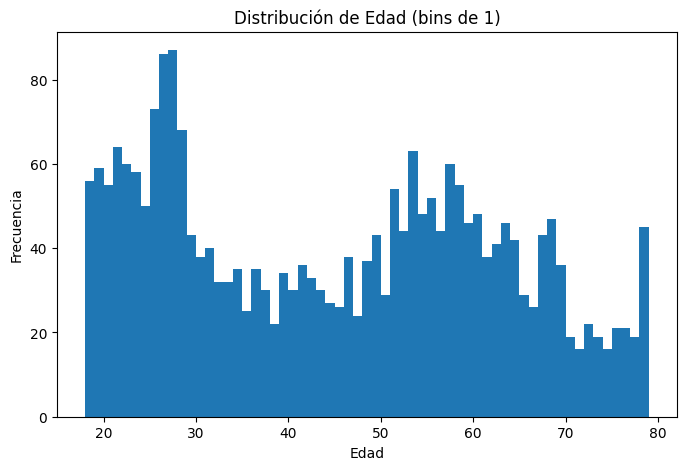

In [4]:
# Edad
plt.figure(figsize=(8,5))
plt.hist(
    df['CustomerAge'],
    bins=np.arange(df['CustomerAge'].min(), df['CustomerAge'].max(), 1)
)
plt.xlabel('Edad')
plt.ylabel('Frecuencia')
plt.title('Distribución de Edad (bins de 1)')
plt.show()

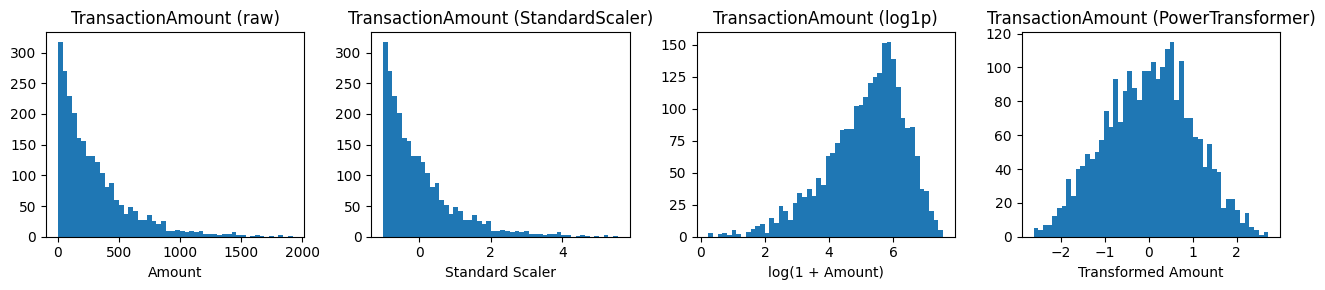

In [5]:

# Datos originales
amount = df['TransactionAmount'].values.reshape(-1, 1)

# StandardScaler
scaler = StandardScaler()
amount_ss = scaler.fit_transform(amount)

# PowerTransformer (Yeo-Johnson)
pt = PowerTransformer(method='yeo-johnson')
amount_pt = pt.fit_transform(amount)

# Visualización
plt.figure(figsize=(13,3))

plt.subplot(1,4,1)
plt.hist(amount, bins=50)
plt.title('TransactionAmount (raw)')
plt.xlabel('Amount')

plt.subplot(1,4,2)
plt.hist(amount_ss, bins=50)
plt.title('TransactionAmount (StandardScaler)')
plt.xlabel('Standard Scaler')

plt.subplot(1,4,3)
plt.hist(np.log1p(amount), bins=50)
plt.title('TransactionAmount (log1p)')
plt.xlabel('log(1 + Amount)')

plt.subplot(1,4,4)
plt.hist(amount_pt, bins=50)
plt.title('TransactionAmount (PowerTransformer)')
plt.xlabel('Transformed Amount')


plt.tight_layout()
plt.show()


In [6]:
skew_raw = pd.Series(amount.flatten()).skew()
skew_ss = pd.Series(amount_ss.flatten()).skew()
skew_log = pd.Series(np.log1p(amount.flatten())).skew()
skew_pt  = pd.Series(amount_pt.flatten()).skew()

print(f"Skew raw: {skew_raw:.2f}")
print(f"Skew StandardScaler: {skew_ss:.2f}")
print(f"Skew log1p: {skew_log:.2f}")
print(f"Skew PowerTransformer: {skew_pt:.2f}")


Skew raw: 1.74
Skew StandardScaler: 1.74
Skew log1p: -0.80
Skew PowerTransformer: -0.05


#### En ambos casos vamos a usar Standar Scaler, para mantener las colas donde normalmente se concentran los fraudes, si usamos otra transformaciónn, aunque se acerce más a una normal, vamos a detectar como fraude a transacciones muy pequeñas, lo cual sería molesto para los usarios.

# Vamos a hacer el modelo no supervisado

## **K-Means Clustering** 

In [7]:
pipeline = Pipeline([
    ('power', StandardScaler()),
    ('scaler', StandardScaler())
])

X_transformed = pipeline.fit_transform(
    df[['TransactionAmount','CustomerAge']]
)

#### Vamos a encontrar los hiperparámetros óptimos para K-MEANS

c:\Users\juanp\AppData\Local\Programs\Python\Python313\Lib\site-packages\joblib\externals\loky\backend\context.py:136: UserWarning: Could not find the number of physical cores for the following reason:
[WinError 2] El sistema no puede encontrar el archivo especificado
Returning the number of logical cores instead. You can silence this warning by setting LOKY_MAX_CPU_COUNT to the number of cores you want to use.
  warnings.warn(
  File "c:\Users\juanp\AppData\Local\Programs\Python\Python313\Lib\site-packages\joblib\externals\loky\backend\context.py", line 257, in _count_physical_cores
    cpu_info = subprocess.run(
        "wmic CPU Get NumberOfCores /Format:csv".split(),
        capture_output=True,
        text=True,
    )
  File "c:\Users\juanp\AppData\Local\Programs\Python\Python313\Lib\subprocess.py", line 554, in run
    with Popen(*popenargs, **kwargs) as process:
         ~~~~~^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\juanp\AppData\Local\Programs\Python\Python313\Lib\subprocess.py

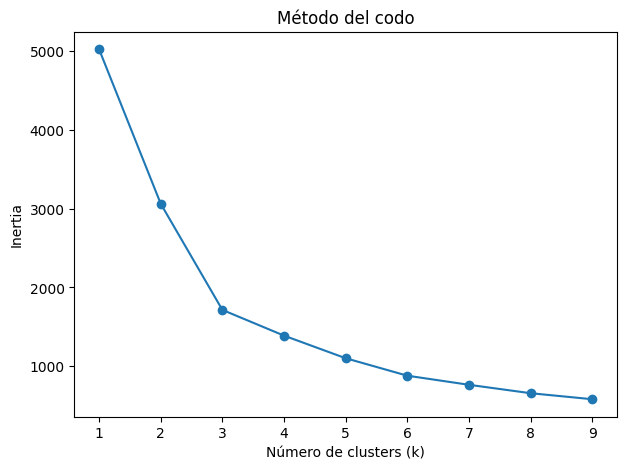

In [8]:
inertias = []
k_range = range(1, 10)

for k in k_range:
    km = KMeans(n_clusters=k, random_state=42, n_init=10)
    km.fit(X_transformed)
    inertias.append(km.inertia_)

plt.figure(figsize=(7,5))
plt.plot(k_range, inertias, marker='o')
plt.xlabel('Número de clusters (k)')
plt.ylabel('Inertia')
plt.title('Método del codo')
plt.show()


#### Vemos que k=3 es el óptimo

In [9]:
kmeans_3 = KMeans(n_clusters=3)

labels_3 = kmeans_3.fit_predict(X_transformed)
centers_3 = kmeans_3.cluster_centers_


In [10]:
sil = silhouette_score(X_transformed, labels_3)
print(f"Silhouette score = {sil:.4f}")

Silhouette score = 0.4696


#### Según esto, es más o menos descenete la organización

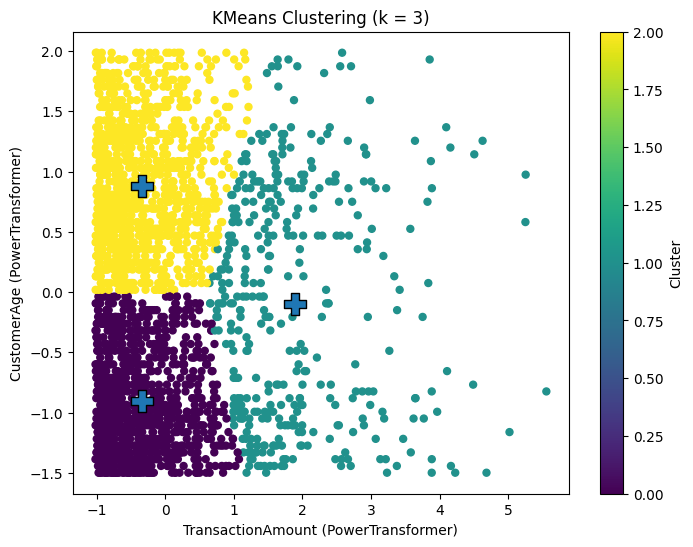

In [11]:
plt.figure(figsize=(8,6))

scatter = plt.scatter(
    X_transformed[:, 0],
    X_transformed[:, 1],
    c=labels_3,
    s=25
)

# Centroides
plt.scatter(
    centers_3[:, 0],
    centers_3[:, 1],
    s=250,
    marker='P',
    edgecolor='black'
)

plt.ylabel('CustomerAge (PowerTransformer)')
plt.xlabel('TransactionAmount (PowerTransformer)')
plt.title('KMeans Clustering (k = 3)')
plt.colorbar(scatter, label='Cluster')
plt.show()


In [12]:
# Distancia euclidiana al centroide asignado
distances = np.linalg.norm(
    X_transformed - centers_3[labels_3],
    axis=1
)

df_kmean = df.copy()
df_kmean['distance_to_centroid'] = distances
threshold_995 = np.percentile(distances, 99.5)
print(f"La distancia es: {threshold_995:.3f}")

La distancia es: 2.509


In [13]:
df_kmean['is_fraud'] = df_kmean['distance_to_centroid'] >= threshold_995
df_kmean['is_fraud'].value_counts(normalize=True)


is_fraud
False    0.994825
True     0.005175
Name: proportion, dtype: float64

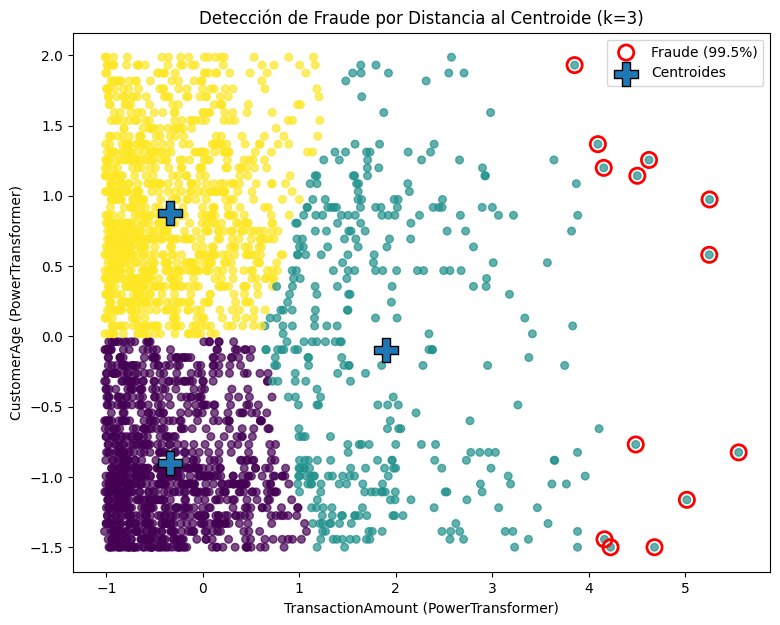

In [14]:
plt.figure(figsize=(9,7))

# Clusters
scatter = plt.scatter(
    X_transformed[:, 0],
    X_transformed[:, 1],
    c=labels_3,
    s=30,
    alpha=0.7
)

# Fraudes
frauds = df_kmean['is_fraud'].values
plt.scatter(
    X_transformed[frauds, 0],
    X_transformed[frauds, 1],
    s=120,
    facecolors='none',
    edgecolors='red',
    linewidths=2,
    label='Fraude (99.5%)'
)

# Centroides
plt.scatter(
    centers_3[:, 0],
    centers_3[:, 1],
    s=300,
    marker='P',
    edgecolor='black',
    label='Centroides'
)

plt.ylabel('CustomerAge (PowerTransformer)')
plt.xlabel('TransactionAmount (PowerTransformer)')
plt.title('Detección de Fraude por Distancia al Centroide (k=3)')
plt.legend()
plt.show()


## **DBSCAN**

In [15]:
X = X_transformed  # CustomerAge + TransactionAmount transformados de antes
k = 4  # igual a min_samples, 2 x la dim

#### Vamos a encontrar los hiperparámetros óptimos para DBSCAN

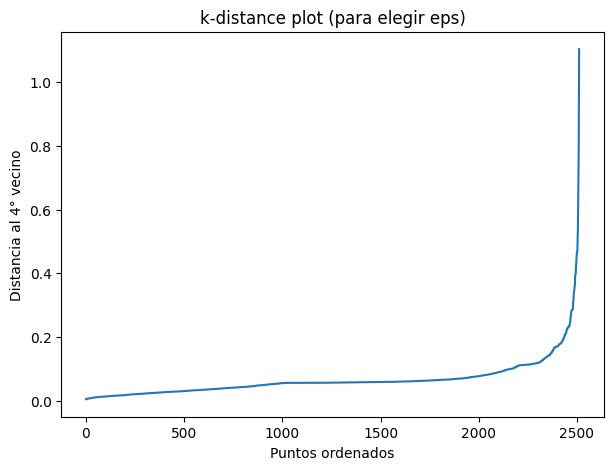

In [16]:
neighbors = NearestNeighbors(n_neighbors=k)
neighbors_fit = neighbors.fit(X)
distances, indices = neighbors_fit.kneighbors(X)

# Tomamos la distancia al k-ésimo vecino
k_distances = np.sort(distances[:, k-1])

plt.figure(figsize=(7,5))
plt.plot(k_distances)
plt.xlabel('Puntos ordenados')
plt.ylabel(f'Distancia al {k}° vecino')
plt.title('k-distance plot (para elegir eps)')
plt.show()


In [17]:
eps = 0.18  # Gráfica de arriba

In [18]:
dbscan = DBSCAN(
    eps=eps,
    min_samples=k
)

db_labels = dbscan.fit_predict(X)


In [19]:
df_dbscan = df.copy()
df_dbscan['dbscan_cluster'] = db_labels
df_dbscan['dbscan_cluster'].value_counts()

dbscan_cluster
 0     2381
-1       57
 6        9
 1        8
 2        7
 8        7
 3        6
 5        6
 4        5
 7        5
 10       5
 12       4
 13       4
 9        4
 11       4
Name: count, dtype: int64

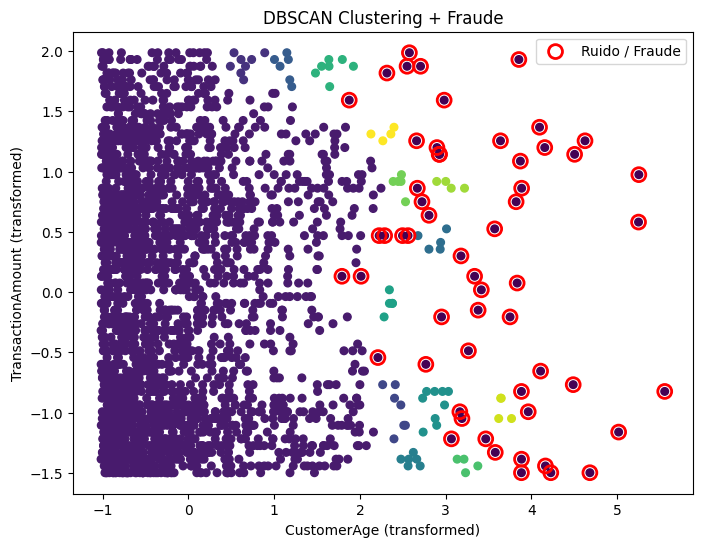

In [20]:
plt.figure(figsize=(8,6))

plt.scatter(
    X[:,0],
    X[:,1],
    c=db_labels,
    s=30
)

# Resaltar ruido
noise = db_labels == -1
plt.scatter(
    X[noise,0],
    X[noise,1],
    s=100,
    facecolors='none',
    edgecolors='red',
    linewidths=2,
    label='Ruido / Fraude'
)

plt.xlabel('CustomerAge (transformed)')
plt.ylabel('TransactionAmount (transformed)')
plt.title('DBSCAN Clustering + Fraude')
plt.legend()
plt.show()


In [21]:
(df_dbscan['dbscan_cluster'] == -1).mean()


np.float64(0.02269108280254777)